In [ ]:
# Сылка на соревнование https://www.kaggle.com/c/sf-dst-scoring/data?select=train.csv

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
train = pd.read_csv(r"C:\Users\Alexey\Desktop\python_and_data_an\компьютер говорит нет\train.csv")
test = pd.read_csv(r"C:\Users\Alexey\Desktop\python_and_data_an\компьютер говорит нет\test.csv")
sample_submission = pd.read_csv(r"C:\Users\Alexey\Desktop\python_and_data_an\компьютер говорит нет\sample_submission.csv")

### Пропуски

In [41]:
def give_education(df, i):
    education = "SCH"
    if df["foreign_passport"][i] == "Y":
        if df["car_type"][i] == "Y":
            education = "GRD"
        if df["car_type"][i] == "N" and df["sex"][i] == "M":
            education = "GRD"
    return education

for i in range(0, len(train)):
    if train["education"].isna()[i]:
        train["education"][i] = give_education(train, i)

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73799 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [43]:
for i in range(0, len(test)):
    if test["education"].isna()[i]:
        test["education"][i] = give_education(test, i)

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36349 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

# Машинка

In [45]:
# По-нормальному

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

cat_cols = ['education', 'home_address', 'work_address']

num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']

In [46]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.transform(test[column])

In [48]:
# убедимся в преобразовании    
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


In [49]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0


In [50]:
# One Hot Encoding
one_hot_enc = OneHotEncoder(sparse = False)
X_cat_train = one_hot_enc.fit_transform(train[cat_cols].values)
X_cat_test = one_hot_enc.transform(test[cat_cols].values)

In [51]:
# Стандартизация числовых переменных
sasc = StandardScaler()
X_num_train = sasc.fit_transform(train[num_cols].values)
X_num_test = sasc.transform(test[num_cols].values)

In [151]:
# Объединяем

X_train = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
Y_train = train['default'].values
X_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
# Y_test = test['default'].values

Произошла маленькая ошибка. Было мнение, что файл test.csv нужен для теста, собственно. А он нужен, чтобы на нём получить ответы и самих ответов в нём нет. Логично. Но вышла соответствующая накладка в названиях переменных. Так что для обучения модели тренировочные и тестовые данные создадим на созданной тренировочной выборке, а та тестовая, в названии которой большие буквы, останется для получения ответа.

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

### Обучение моделей

###### Линейная регрессия

In [60]:
model_LR = LogisticRegression().fit(x_train, y_train)
y_pred = model_LR.predict(x_test)
probs = model_LR.predict_proba(x_test)
probs = probs[:,1]

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


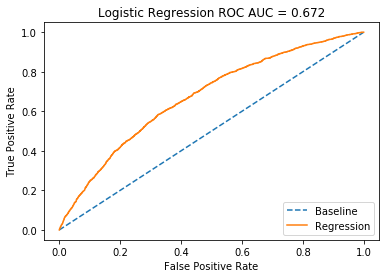

In [61]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [62]:
roc_auc

0.6716166655895817

In [63]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Othe

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Othe

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs_Mine_Different_Else_Othe

Лучшее Penalty: l1
Лучшее C: 1.0


In [88]:
model_LR = LogisticRegression(penalty='l1', C=1.0).fit(x_train, y_train)
y_pred_LR = model_LR.predict(x_test)
probs_LR = model_LR.predict_proba(x_test)
probs_LR = probs_LR[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs_LR)
roc_auc_LR = roc_auc_score(y_test, probs_LR)
roc_auc_LR

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6716343560223291

#####  Гиперпарамеры позволили получить улучшение в пятом знаке после запятой. Наверное, несколько лишних правильных ответов, которым это соответствует, это неплохо.

###### XGBoost

In [91]:
from xgboost import XGBClassifier
model_XGB = XGBClassifier().fit(x_train, y_train)

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [92]:
y_pred_XGB = model_XGB.predict(x_test)
probs_XGB = model_XGB.predict_proba(x_test)
probs_XGB = probs_XGB[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs_XGB)
roc_auc_XGB = roc_auc_score(y_test, probs_XGB)
roc_auc_XGB

0.6632433563220084

In [81]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]

# Создадим гиперпараметры
hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)

model = XGBClassifier()
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# View best hyperparameters
print('Лучшее n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Лучшее max_depth:', best_model.best_estimator_.get_params()['max_depth'])

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:24:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:25:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Лучшее n_estimators: 50
Лучшее max_depth: 2


In [93]:
model_XGB = XGBClassifier(n_estimators = 50, max_depth = 2).fit(x_train, y_train)
y_pred_XGB = model_XGB.predict(x_test)
probs_XGB = model_XGB.predict_proba(x_test)
probs_XGB = probs_XGB[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs_XGB)
roc_auc_XGB = roc_auc_score(y_test, probs_XGB)
roc_auc_XGB

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6793334608906643

#####  Гиперпарамеры позволили неплохо улучшить качество работы. Увеличение во втором знаке после запятой.

In [84]:
from sklearn.svm import SVC
model_SVC = SVC(probability=True).fit(x_train, y_train)

C:\Programs_Mine_Different_Else_Other\Anaconda_2019Download\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


NameError: name 'model_SVC' is not defined

In [90]:
y_pred_SVC = model_SVC.predict(x_test)
probs_SVC = model_SVC.predict_proba(x_test)
probs_SVC = probs_SVC[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs_SVC)
roc_auc_SVC = roc_auc_score(y_test, probs_SVC)
roc_auc_SVC

0.5246699009687035

###### Обучается долго. Гиперпараметры подбирать не буду.

Пробуем голосование

In [139]:
probs_list = []
probs_list.append(probs_LR.tolist())
probs_list.append(probs_XGB.tolist())
probs_list.append(probs_SVC.tolist())

summ = roc_auc_LR + roc_auc_XGB + roc_auc_SVC
weights = [roc_auc_LR/summ, roc_auc_XGB/summ, roc_auc_SVC/summ]

probs_democratos = []
for j in range(0, len(probs_list[0])):
    probs_democratos.append(0)
    
for i in range(0, len(weights)):
    for j in range(0, len(probs_list[0])):
        probs_democratos[j] += probs_list[i][j]*weights[i]

In [143]:
roc_auc = roc_auc_score(y_test, np.array(probs_democratos))
roc_auc

0.677988988001866

Плохой результат

In [192]:
probs_list = []
probs_list.append(probs_LR.tolist())
probs_list.append(probs_XGB.tolist())
probs_list.append(probs_SVC.tolist())

weights = [0.333333, 0.333333, 0.333333]

probs_democratos = []
for j in range(0, len(probs_list[0])):
    probs_democratos.append(0)
    
for i in range(0, len(weights)):
    for j in range(0, len(probs_list[0])):
        probs_democratos[j] += probs_list[i][j]*weights[i]

In [193]:
roc_auc = roc_auc_score(y_test, np.array(probs_democratos))
roc_auc

0.6779591935888178

Плохой результат. Попробую без SVC.

In [146]:
probs_list = []
probs_list.append(probs_LR.tolist())
probs_list.append(probs_XGB.tolist())

summ = roc_auc_LR + roc_auc_XGB
weights = [roc_auc_LR/summ, roc_auc_XGB/summ]

probs_democratos = []
for j in range(0, len(probs_list[0])):
    probs_democratos.append(0)
    
for i in range(0, len(weights)):
    for j in range(0, len(probs_list[0])):
        probs_democratos[j] += probs_list[i][j]*weights[i]

In [147]:
roc_auc = roc_auc_score(y_test, np.array(probs_democratos))
roc_auc

0.6780224643949357

Плохой результат. Хотя лучше, чем прошлые попытки голосования

In [148]:
probs_list = []
probs_list.append(probs_LR.tolist())
probs_list.append(probs_XGB.tolist())

weights = [0.5, 0.5]

probs_democratos = []
for j in range(0, len(probs_list[0])):
    probs_democratos.append(0)
    
for i in range(0, len(weights)):
    for j in range(0, len(probs_list[0])):
        probs_democratos[j] += probs_list[i][j]*weights[i]

In [149]:
roc_auc = roc_auc_score(y_test, np.array(probs_democratos))
roc_auc

0.6780062128969095

Плохой результат. Хуже прошлого.

Вердикт: XGBoost показал (с гиперпараметрами) лучшие результаты. Хотя, казалось бы, странно. Должно было быть лучше у системы голосования. Дело может быть в том, что неправильно складывались вероятности, недостаточно эффективные модели создавались или просто надо было попробовать взять ещё какую-нибудь модель и обучить её на ответах трёх выбранных. Можно ещё поработать со значимостями входных данных?..

В любом случае, оставим, как есть. Осталось обучить лучшую модель с выбранными всеми гиперпараметрами на всех данных и получить для неё ответы. И отправить их. И всё. Ага.

In [167]:
model_best = XGBClassifier(n_estimators = 50, max_depth = 2).fit(X_train, Y_train)
y_pred_best = model_best.predict(X_test)
probs_best = model_best.predict_proba(X_test)
probs_best = probs_best[:,1]

[17:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [186]:
data = {'client_id':test["client_id"], 'default':probs_best.tolist()}

In [201]:
result = pd.DataFrame(data)

In [190]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [188]:
result

,client_id,default
0,74835,0.070533
1,17527,0.196989
2,75683,0.055262
3,26883,0.103784
4,28862,0.073811
...,...,...
36344,83775,0.321521
36345,106254,0.061874
36346,81852,0.144178
36347,1971,0.234742


In [203]:
result.to_csv('result.csv', index = False)